In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from numerical_mapping import *
from physico_chemical import *
from CGR import *
from basic_encoding import *
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from utils import *

# Load data

- select a dataset
- load train, validation and test data
- look at data distribution
- extract sequences to generate features

In [2]:
root_dir = "datasets"
subdirs = get_all_subdirs(root_dir)

dropdown = widgets.Dropdown(
    options=subdirs,
    description='Select:',
    disabled=False,
)

selected_path = {'value': None}

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_path['value'] = change['new']

dropdown.observe(on_change)

display(dropdown)

Dropdown(description='Select:', options=('datasets\\GUE\\EMP\\H3', 'datasets\\GUE\\EMP\\H3K14ac', 'datasets\\G…

In [3]:
train_data=pd.read_csv(selected_path['value']+'\\train.csv')
val_data=pd.read_csv(selected_path['value']+'\\dev.csv')
test_data=pd.read_csv(selected_path['value']+'\\test.csv')
data={'Train':train_data,'Val':val_data,'Test':test_data}
train_data.head(5)

,sequence,label
0,TATAATAATAACGAAGATGAGACGACAGTCGACAAGAAAAGCACCA...,0
1,AAAGCCCGAGCGGCGGCCACGCCTCGGTGGCGATTTTATTAGCGCT...,1
2,AGTCCGCGATATTCTGAGGGGACTTTCGACACAAAAAAGTTGACAC...,0
3,ACCCCCCGGCCCCGCCCCACAGACCCCTCCAGTGGTCCCCCGGCCA...,1
4,AGGTCTTTGGTCCCCCAACCCTGTGCTCTTTCCACTTAAATCCCGA...,1


In [4]:
max_length=len(train_data['sequence'][0])
max_length

300

Text(0.5, 1.0, 'Data Distribution')

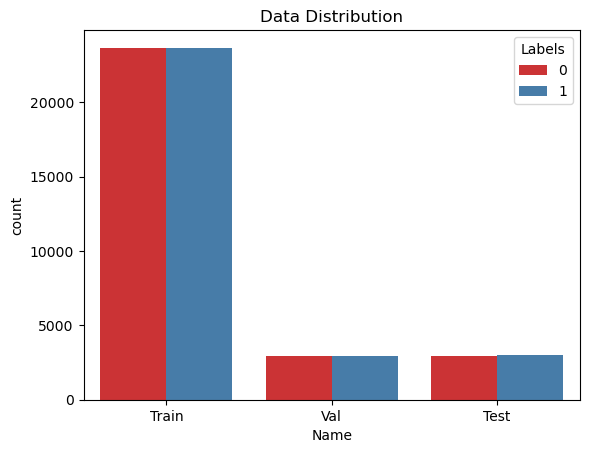

In [5]:
labels=[]
dataname=[]
for d in data:
    labels.extend((data[d])['label'])
    dataname.extend([d]*len(data[d].index))
label_distr=pd.DataFrame({'Labels':labels,'Name':dataname})
sns.countplot(label_distr,x='Name',hue='Labels',palette='Set1')
plt.title('Data Distribution')

In [6]:
sequences={}

for d in data:
    sequences[d]=(data[d])['sequence']
    
pd.DataFrame(sequences).head(5)

,Train,Val,Test
0,TATAATAATAACGAAGATGAGACGACAGTCGACAAGAAAAGCACCA...,TAAATACGGAAGTTTATTACTTGAGGAATAGATGGAATCGTCGGGC...,CTAAATATTAACTGGTCTTGTGAGATGTCTTCTTGGCTGGAGCCTG...
1,AAAGCCCGAGCGGCGGCCACGCCTCGGTGGCGATTTTATTAGCGCT...,CGGGCCTGCCCCTCCGAGGCGCCGTAGCGCGGGAGGGAGGCGGCGG...,CAGCCTCTCGACCGCCGGCCACCCGCCAGCCACGCGCGCCCAGACA...
2,AGTCCGCGATATTCTGAGGGGACTTTCGACACAAAAAAGTTGACAC...,CTGGGGGTTGGGCCAGCAGCTTCTCAGCACCAGGATCATGACTCTG...,GTGGGATCCCCACGGACCTGGAAATTCTCGCCTGTCTTCCCTTCAC...
3,ACCCCCCGGCCCCGCCCCACAGACCCCTCCAGTGGTCCCCCGGCCA...,GTTGTGAGAGAGCCGCAGGGTCCTGACTCACTCAGAGCTGCCTGTC...,TGGACTTCGGGAACACCGCGTACCTGCGGGGGCACAGCCCCACCCG...
4,AGGTCTTTGGTCCCCCAACCCTGTGCTCTTTCCACTTAAATCCCGA...,TATGCAAATGACAGGCAAAGCCGCTTGCAAATAACCTGGCGAAGCG...,CTCTCAACCCCTGTTTATTTATCCCATAAATATTTATTAAATGATT...


# Extract Features

- from sequences extract each feature
- create combined feature set

## Basic Encodings

### One-Hot

What: Binary vector representing each nucleotide (e.g., A = [1,0,0,0]).

When to Use: Deep learning, where fixed input formats are needed.

Drawbacks: High dimensionality, ignores sequence context, no similarity captured.

<p align="center">
  <img src="images\OneHot.png" alt="Description" width="300">
</p>

In [7]:
one_hot_feat=pd.DataFrame()
for seq_set in sequences:
    one_hot_feat=pd.concat([one_hot_feat,pd.DataFrame(one_hot_encode_sequences(sequences[seq_set]))])
one_hot_feat

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,0,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,1,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
5916,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
5917,0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
5918,0,0,0,1,1,0,0,0,0,1,...,1,0,0,1,0,0,0,1,0,0


### K-mer

What: Counts frequency of subsequences of length k (e.g., all 3-mers in a DNA string).

When to Use: Feature engineering for ML models, sequence comparison.

Drawbacks: Loses global order, large k leads to sparse high-dimensional space.

<p align="center">
  <img src="images\kmer.png" alt="Description" width="300">
</p>

In [8]:
kmer_feat=pd.DataFrame()
for seq_set in sequences:
    kmer_feat=pd.concat([kmer_feat,pd.DataFrame(generate_kmer_features(sequences[seq_set],4))])
kmer_feat

,A,C,G,T,AA,AC,AG,AT,CA,CC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.260000,0.266667,0.313333,0.160000,0.066890,0.060201,0.076923,0.056856,0.073579,0.080268,...,0.000000,0.000000,0.003367,0.006734,0.006734,0.000000,0.003367,0.000000,0.000000,0.000000
1,0.106667,0.313333,0.443333,0.136667,0.010033,0.020067,0.060201,0.013378,0.010033,0.123746,...,0.000000,0.000000,0.000000,0.000000,0.006734,0.006734,0.003367,0.003367,0.000000,0.003367
2,0.243333,0.266667,0.230000,0.260000,0.096990,0.056856,0.036789,0.053512,0.060201,0.063545,...,0.006734,0.013468,0.010101,0.006734,0.010101,0.000000,0.000000,0.010101,0.016835,0.006734
3,0.093333,0.340000,0.480000,0.086667,0.003344,0.030100,0.056856,0.003344,0.036789,0.140468,...,0.000000,0.000000,0.000000,0.003367,0.000000,0.000000,0.000000,0.003367,0.003367,0.000000
4,0.220000,0.283333,0.330000,0.166667,0.043478,0.063545,0.093645,0.016722,0.073579,0.086957,...,0.000000,0.006734,0.000000,0.000000,0.006734,0.000000,0.000000,0.006734,0.003367,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,0.130000,0.353333,0.360000,0.156667,0.016722,0.040134,0.056856,0.016722,0.036789,0.120401,...,0.000000,0.000000,0.003367,0.000000,0.003367,0.003367,0.000000,0.003367,0.003367,0.000000
5916,0.270000,0.203333,0.170000,0.356667,0.070234,0.053512,0.066890,0.080268,0.060201,0.053512,...,0.000000,0.013468,0.013468,0.006734,0.006734,0.003367,0.016835,0.013468,0.016835,0.023569
5917,0.190000,0.306667,0.296667,0.206667,0.063545,0.033445,0.060201,0.033445,0.056856,0.083612,...,0.003367,0.000000,0.003367,0.003367,0.003367,0.003367,0.003367,0.000000,0.003367,0.000000
5918,0.193333,0.310000,0.286667,0.210000,0.036789,0.080268,0.053512,0.023411,0.060201,0.120401,...,0.000000,0.000000,0.000000,0.003367,0.010101,0.010101,0.010101,0.000000,0.006734,0.000000


## Numerical Mapping


### Integer

What: Encodes nucleotides as integers (e.g., A=0, C=1, G=2, T=3).

When to Use: Simple ML models, sequence alignment, indexing.

Drawbacks: Imposes false ordinal relationships; lacks biological meaning.

<p align="center">
  <img src="images\integer.png" alt="Description" width="300">
</p>

In [9]:
integer_feat=pd.DataFrame()
for seq_set in sequences:
    integer_feat=pd.concat([integer_feat,pd.DataFrame(integer_features(sequences[seq_set],max_length))])
integer_feat

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0,2,0,2,2,0,2,2,0,2,...,1,0,3,1,3,1,1,3,2,3
1,2,2,2,3,1,1,1,3,2,3,...,3,3,1,3,3,1,0,1,1,2
2,2,3,0,1,1,3,1,3,2,0,...,1,1,1,2,3,1,0,3,1,3
3,2,1,1,1,1,1,1,3,3,1,...,1,1,0,0,1,1,1,1,2,3
4,2,3,3,0,1,0,0,0,3,3,...,2,3,3,1,1,1,1,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,2,0,1,1,0,3,1,0,2,2,...,1,1,3,3,1,1,0,0,0,3
5916,0,0,0,2,0,3,3,2,1,0,...,1,1,2,0,1,0,0,0,0,1
5917,1,0,1,2,0,2,2,3,1,1,...,0,0,3,1,0,0,3,0,0,1
5918,0,2,1,2,2,3,1,1,3,2,...,3,3,0,3,3,3,2,3,1,1


### Z-curve

What: 3D curve representation based on nucleotide distribution.

When to Use: Genome comparison, gene identification.

Drawbacks: Complex to compute and interpret; limited to certain applications.

<p align="center">
  <img src="images\Z-curve.png" alt="Description" width="300">
</p>

In [10]:
zcurve_feat=pd.DataFrame()
for seq_set in sequences:
    zcurve_feat=pd.concat([zcurve_feat,pd.DataFrame(zcurve_features(sequences[seq_set],max_length))])
zcurve_feat

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,-1,0,-1,0,1,0,1,2,1,2,...,-43,-42,-43,-44,-45,-46,-47,-48,-47,-48
1,1,2,3,4,3,2,1,2,3,4,...,-149,-150,-151,-152,-153,-154,-153,-154,-155,-154
2,1,2,1,0,-1,0,-1,0,1,0,...,7,6,5,6,5,4,5,4,3,2
3,1,0,-1,-2,-3,-4,-5,-4,-3,-4,...,-189,-190,-189,-188,-189,-190,-191,-192,-191,-192
4,1,2,3,2,1,0,-1,-2,-1,0,...,-63,-64,-65,-66,-67,-68,-69,-70,-69,-68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,1,0,-1,-2,-3,-2,-3,-4,-3,-2,...,-125,-126,-127,-128,-129,-130,-129,-128,-127,-128
5916,-1,-2,-3,-2,-3,-2,-1,0,-1,-2,...,73,72,73,74,73,74,75,76,77,76
5917,-1,-2,-3,-2,-3,-2,-1,0,-1,-2,...,-63,-62,-63,-64,-63,-62,-63,-62,-61,-62
5918,-1,0,-1,0,1,2,1,0,1,2,...,-53,-54,-53,-54,-55,-56,-55,-56,-57,-58


## Pysico-Chemical Features

### GC Content

What: Proportion of G and C nucleotides.

When to Use: Genome classification, stability prediction.

Drawbacks: Very coarse; ignores sequence order and context.

<p align="center">
  <img src="images\GC.png" alt="Description" width="300">
</p>

In [11]:
gc_feat=pd.DataFrame()
for seq_set in sequences:
    gc_feat=pd.concat([gc_feat,pd.DataFrame(gc_content_features(sequences[seq_set]))])
gc_feat

,GC_Content,G_Count,C_Count,Length
0,0.580000,94,80,300
1,0.756667,133,94,300
2,0.496667,69,80,300
3,0.820000,144,102,300
4,0.613333,99,85,300
...,...,...,...,...
5915,0.713333,108,106,300
5916,0.373333,51,61,300
5917,0.603333,89,92,300
5918,0.596667,86,93,300


### Global Descriptors

What: Aggregated statistical features 

When to Use: Classification tasks, especially in ML.

Drawbacks: May lose local sequence information; interpretation can be difficult.

<p align="center">
  <img src="images\GD.png" alt="Description" width="300">
</p>

In [12]:
gd_feat=pd.DataFrame()
for seq_set in sequences:
    gd_feat=pd.concat([gd_feat,pd.DataFrame(global_descriptor_features(sequences[seq_set]))])
gd_feat

,Comp_A,Comp_C,Comp_G,Comp_T,Trans_TA,Trans_AT,Trans_AA,Trans_AC,Trans_CG,Trans_GA,...,Dist_G_0,Dist_G_1,Dist_G_2,Dist_G_3,Dist_G_4,Dist_T_0,Dist_T_1,Dist_T_2,Dist_T_3,Dist_T_4
0,0.260000,0.266667,0.313333,0.160000,0.040134,0.056856,0.066890,0.060201,0.076923,0.080268,...,0.040000,0.296667,0.460000,0.696667,0.996667,0.000000,0.376667,0.603333,0.823333,0.970000
1,0.106667,0.313333,0.443333,0.136667,0.020067,0.013378,0.010033,0.020067,0.133779,0.063545,...,0.010000,0.286667,0.596667,0.770000,0.980000,0.076667,0.163333,0.330000,0.826667,0.986667
2,0.243333,0.266667,0.230000,0.260000,0.030100,0.053512,0.096990,0.056856,0.083612,0.053512,...,0.003333,0.190000,0.460000,0.790000,0.996667,0.006667,0.240000,0.443333,0.646667,0.986667
3,0.093333,0.340000,0.480000,0.086667,0.003344,0.003344,0.003344,0.030100,0.137124,0.046823,...,0.023333,0.313333,0.493333,0.726667,0.996667,0.090000,0.280000,0.640000,0.843333,0.976667
4,0.220000,0.283333,0.330000,0.166667,0.020067,0.016722,0.043478,0.063545,0.053512,0.080268,...,0.003333,0.326667,0.480000,0.773333,0.990000,0.010000,0.120000,0.240000,0.580000,0.993333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,0.130000,0.353333,0.360000,0.156667,0.016722,0.016722,0.016722,0.040134,0.123746,0.056856,...,0.016667,0.316667,0.590000,0.783333,0.996667,0.003333,0.183333,0.410000,0.803333,0.993333
5916,0.270000,0.203333,0.170000,0.356667,0.076923,0.080268,0.070234,0.053512,0.003344,0.063545,...,0.016667,0.203333,0.466667,0.686667,0.960000,0.000000,0.306667,0.620000,0.773333,0.993333
5917,0.190000,0.306667,0.296667,0.206667,0.023411,0.033445,0.063545,0.033445,0.083612,0.046823,...,0.023333,0.266667,0.563333,0.803333,0.986667,0.003333,0.243333,0.686667,0.853333,0.993333
5918,0.193333,0.310000,0.286667,0.210000,0.040134,0.023411,0.036789,0.080268,0.060201,0.056856,...,0.016667,0.296667,0.553333,0.790000,0.990000,0.000000,0.290000,0.476667,0.723333,0.973333


## Advanced Representations

### Chaos Game Representation

What: Fractal-like image encoding sequence as 2D patterns.

When to Use: Visual pattern recognition, deep learning on images.

Drawbacks: Computationally heavy for long sequences; hard to interpret directly.

<p align="center">
  <img src="images\CGR.png" alt="Description" width="300">
</p>


In [13]:
cgr_feat=pd.DataFrame()
for seq_set in sequences:
    cgr_feat=pd.concat([cgr_feat,pd.DataFrame(classifical_chaos_features(sequences[seq_set],max_length))])
cgr_feat

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.5,0.25,-0.375,0.3125,0.65625,-0.171875,0.414062,0.707031,-0.146484,0.426758,...,-0.676985,0.161508,-0.419246,-0.709623,-0.854812,-0.927406,-0.963703,-0.981851,0.009074,-0.495463
1,0.5,0.75,0.875,0.9375,-0.03125,-0.515625,-0.757812,0.121094,0.560547,0.780273,...,-0.062438,-0.531219,-0.765609,-0.882805,-0.941402,-0.970701,0.014649,-0.492675,-0.746338,0.126831
2,0.5,0.75,-0.125,-0.5625,-0.78125,0.109375,-0.445312,0.277344,0.638672,-0.180664,...,-0.964322,-0.982161,-0.991080,0.004460,-0.497770,-0.748885,0.125557,-0.437221,-0.718611,-0.859305
3,0.5,-0.25,-0.625,-0.8125,-0.90625,-0.953125,-0.976562,0.011719,0.505859,-0.247070,...,-0.687179,-0.843589,0.078205,0.539103,-0.230449,-0.615224,-0.807612,-0.903806,0.048097,-0.475952
4,0.5,0.75,0.875,-0.0625,-0.53125,-0.765625,-0.882812,-0.941406,0.029297,0.514648,...,0.160263,-0.419868,-0.709934,-0.854967,-0.927484,-0.963742,-0.981871,-0.990935,0.004532,0.502266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,0.5,-0.25,-0.625,-0.8125,-0.90625,0.046875,-0.476562,-0.738281,0.130859,0.565430,...,-0.984237,-0.992119,-0.996059,-0.998030,-0.999015,-0.999507,0.000246,0.500123,0.750062,-0.124969
5916,-0.5,-0.75,-0.875,0.0625,-0.46875,0.265625,0.632812,0.816406,-0.091797,-0.545898,...,-0.750325,-0.875162,0.062419,0.531209,-0.234395,0.382802,0.691401,0.845701,0.922850,-0.038575
5917,-0.5,-0.75,-0.875,0.0625,-0.46875,0.265625,0.632812,0.816406,-0.091797,-0.545898,...,0.274453,0.637226,-0.181387,-0.590693,0.204653,0.602327,-0.198837,0.400582,0.700291,-0.149855
5918,-0.5,0.25,-0.375,0.3125,0.65625,0.828125,-0.085938,-0.542969,0.228516,0.614258,...,-0.946686,-0.973343,0.013328,-0.493336,-0.746668,-0.873334,0.063333,-0.468333,-0.734167,-0.867083


## Combine 

In [14]:
combined_feat_set=pd.concat([one_hot_feat,kmer_feat,integer_feat,zcurve_feat,gc_feat,gd_feat,cgr_feat],axis=1)
combined_feat_set.columns=[i for i in range(0,len(combined_feat_set.keys()))]
combined_feat_set

,0,1,2,3,4,5,6,7,8,9,...,3374,3375,3376,3377,3378,3379,3380,3381,3382,3383
0,0,0,0,1,1,0,0,0,0,0,...,-0.676985,0.161508,-0.419246,-0.709623,-0.854812,-0.927406,-0.963703,-0.981851,0.009074,-0.495463
1,1,0,0,0,1,0,0,0,1,0,...,-0.062438,-0.531219,-0.765609,-0.882805,-0.941402,-0.970701,0.014649,-0.492675,-0.746338,0.126831
2,1,0,0,0,0,0,1,0,0,0,...,-0.964322,-0.982161,-0.991080,0.004460,-0.497770,-0.748885,0.125557,-0.437221,-0.718611,-0.859305
3,1,0,0,0,0,1,0,0,0,1,...,-0.687179,-0.843589,0.078205,0.539103,-0.230449,-0.615224,-0.807612,-0.903806,0.048097,-0.475952
4,1,0,0,0,0,0,1,0,0,0,...,0.160263,-0.419868,-0.709934,-0.854967,-0.927484,-0.963742,-0.981871,-0.990935,0.004532,0.502266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,1,0,0,0,0,0,0,1,0,1,...,-0.984237,-0.992119,-0.996059,-0.998030,-0.999015,-0.999507,0.000246,0.500123,0.750062,-0.124969
5916,0,0,0,1,0,0,0,1,0,0,...,-0.750325,-0.875162,0.062419,0.531209,-0.234395,0.382802,0.691401,0.845701,0.922850,-0.038575
5917,0,1,0,0,0,0,0,1,0,1,...,0.274453,0.637226,-0.181387,-0.590693,0.204653,0.602327,-0.198837,0.400582,0.700291,-0.149855
5918,0,0,0,1,1,0,0,0,0,1,...,-0.946686,-0.973343,0.013328,-0.493336,-0.746668,-0.873334,0.063333,-0.468333,-0.734167,-0.867083
